<a href="https://colab.research.google.com/github/manmeet3591/python_class/blob/master/gee/gedi_extract_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raster to vector: https://gis.stackexchange.com/questions/434001/fixingfeaturecollection-error-image-reducetovectors-first-band-rh100-of

After running this script for your region of interest go to the task manager (https://code.earthengine.google.com/tasks) to check if the data has been downloaded to the Google Drive

In [21]:
from google.colab import auth
auth.authenticate_user()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import ee, folium

In [23]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=IcMhUnKFfobhi1-PHcEuk6J7jr9waRAGwz54msjowoY&tc=4bl0iM9mEvEXJ1sFKcS3NPGRW6218GkbLvnhhbhV3Xo&cc=bLt034zwlaZVF0TGB-4MANfxQfdL7hu67y9vXvrBPWk

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qjLBV72ldhuBiOaoSckFTOA_phVHjTHPViL5XiuKVEwJOtTOXt7KBI

Successfully saved authorization token.


In [24]:
!sudo add-apt-repository ppa:ubuntugis/ppa
!sudo apt-get update
!sudo apt-get install gdal-bin libgdal-dev
!pip install -U pip
!pip install rasterio

 Official stable UbuntuGIS packages.


 More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com

In [25]:
try:
    import geopandas as gpd
    import shapefile
    from osgeo import ogr,osr,gdal
except:
    !pip install geopandas
    !pip install PyShp
    !pip install gdal
import geopandas as gpd
import shapefile
import numpy as np
import os
import time
from osgeo import ogr,osr,gdal
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
def qualityMask(im):
    return im.updateMask(im.select('quality_flag').eq(1)).updateMask(im.select('degrade_flag').eq(0))
dataset = ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY').map(qualityMask).select('rh98')

In [29]:
visualization = {
  'min': 1.0,
  'max': 60.0,
  'palette': ['darkred','red','orange','green','darkgreen']
  #'bands': ['B4', 'B3', 'B2'],
}

map = folium.Map(location=[1.64, 110.20],zoom_start=4, height=1000,width=1500)
mapid = dataset.getMapId(visualization)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='GEDI',
    opacity=0.5,
  ).add_to(map)

map.add_child(folium.LayerControl())
title_html = '''
             <h3 align="center" style="font-size:10px"><b>'GEDI RH98'</b></h3>
             '''
map.get_root().html.add_child(folium.Element(title_html))
map

In [30]:
aoi = ee.Geometry.Polygon(
        [[[10.752981103928594, 0.7627966289396413],
          [10.752981103928594, -0.7615114430026542],
          [13.104055322678594, -0.7615114430026542],
          [13.104055322678594, 0.7627966289396413]]], np.nan, False)

In [31]:
#// GEDI pre-processing
def func_(image):
    return image.updateMask(image.select('sensitivity').gt(0.98)).updateMask(image.select('quality_flag').eq(1)).updateMask(image.select('degrade_flag').eq(0)).select('rh100').toInt()

gedi = ee.ImageCollection('LARSE/GEDI/GEDI02_A_002_MONTHLY').filterBounds(aoi).map(func_)

In [ ]:
projection = gedi.first().projection().aside(print)
scale = projection.nominalScale().aside(print)
mosaic = gedi.mosaic().setDefaultProjection(crs=projection, scale=scale)
mosaicMask = mosaic.lt(60)
mosaic = mosaic.updateMask(mosaicMask)
#//print(mosaic)   


referenceData = mosaic.reduceToVectors(geometry = aoi,
      geometryType= 'polygon',
      scale = scale,
      maxPixels = 100e9,
      tileScale=16,
      crs = projection,
          )

In [ ]:
task = ee.batch.Export.table.toDrive(
            collection= referenceData,
            folder= 'gedi',
            description='referenceData',
            fileFormat= 'SHP'
)
task.start()

In [42]:
u_lon = 116.2621
u_lat = 39.8412
u_poi = ee.Geometry.Point(u_lon, u_lat)
# Create a buffer zone of 10 km around Lyon.
lyon = u_poi.buffer(100000)  # meters

collectionList = dataset.toList(dataset.size())
collectionSize = dataset.size().getInfo()
for i in range(collectionSize):
    ee.batch.Export.image.toDrive(image = ee.Image(collectionList.get(i)).clip(lyon), fileNamePrefix = 'gedi' + str(i + 1), crs='EPSG:4326', fileFormat='GeoTIFF').start()
    os.system('mv drive/MyDrive/gedi.tif drive/MyDrive/ndui/gedi'+str(i+1)+'.tif')
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: ignored

In [3]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 16.7 MB 283 kB/s 
     |████████████████████████████████| 6.3 MB 25.4 MB/s 


In [4]:
import geopandas

In [9]:
df = geopandas.read_file("drive/MyDrive/ndui/referenceData.shp")  

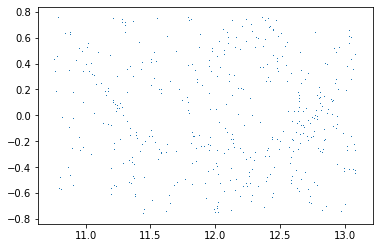

In [15]:
df.plot()

In [20]:
df.head()['geometry']

0    POLYGON ((10.75297 0.76165, 10.75319 0.76165, ...
1    POLYGON ((10.75292 0.64206, 10.75315 0.64206, ...
2    POLYGON ((10.75289 0.53060, 10.75311 0.53060, ...
3    POLYGON ((10.75287 0.43814, 10.75309 0.43814, ...
4    POLYGON ((10.75286 0.43248, 10.75309 0.43248, ...
Name: geometry, dtype: geometry